# **Price Forecasting**

In this project, I implemented various **GARCH family models** to analyze price fluctuations and assess financial risk. The primary objective was to capture volatility dynamics and evaluate risk exposure using GARCH(1,1), EGARCH(1,1), and GJR-GARCH(1,1) models.

# 1. Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

## Load Data

In [2]:
df = pd.read_csv('btcusd_1-min_data.csv')

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944800 entries, 0 to 6944799
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
 6   datetime   object 
dtypes: float64(6), object(1)
memory usage: 370.9+ MB
None
          Timestamp          Open          High           Low         Close  \
count  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06   
mean   1.533756e+09  1.675104e+04  1.675786e+04  1.674401e+04  1.675105e+04   
std    1.202875e+08  2.321404e+04  2.322205e+04  2.320586e+04  2.321406e+04   
min    1.325412e+09  3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00   
25%    1.429584e+09  4.214200e+02  4.215200e+02  4.212700e+02  4.214200e+02   
50%    1.533756e+09  6.497595e+03  6.499950e+03  6.494990e+03  6.497620e+03   
75%    1.637928e+09  2.674500e+04  2.675000e+04  2.674000e+0

## Clean the Data

In [5]:
# Convert timestamp to datetime and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Handle missing values - forward fill for OHLC, 0 for Volume
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].ffill()
df['Volume'].fillna(0, inplace=True)

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

# Remove zero-volume periods (optional - may represent no trading)
df = df[df['Volume'] > 0]

Missing values before cleaning:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_16016\2972859036.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Volume'].fillna(0, inplace=True)


#### Compute Returns and Volatility

- **Returns:** Percentage change in closing prices.
- **Log Returns:** Natural logarithm of price ratio for consecutive periods.
- **Volatility:** Rolling standard deviation of returns annualized for 24 hours.

In [6]:
# Add returns and volatility metrics
df['returns'] = df['Close'].pct_change()
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))
df['volatility'] = df['returns'].rolling(window=24*60).std() * np.sqrt(24*60)  # annualized

#### Resampling Data

Data is resampled to hourly and daily timeframes using aggregation:

- **Open:** First price of the interval.
- **High:** Maximum price within the interval.
- **Low:** Minimum price within the interval.
- **Close:** Last price of the interval.
- **Volume:** Sum of traded volume.

In [7]:
# Resample to different timeframes
hourly_df = df.resample('1H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

daily_df = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print("\nData after cleaning:")
print(df.info())
print(df.head())

C:\Users\milto\AppData\Local\Temp\ipykernel_16016\1813936193.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample('1H').agg({



Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5485238 entries, 2012-01-01 20:28:00+00:00 to 2025-03-15 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Timestamp    float64
 1   Open         float64
 2   High         float64
 3   Low          float64
 4   Close        float64
 5   Volume       float64
 6   returns      float64
 7   log_returns  float64
 8   volatility   float64
dtypes: float64(9)
memory usage: 418.5 MB
None
                              Timestamp  Open  High   Low  Close     Volume  \
datetime                                                                      
2012-01-01 20:28:00+00:00  1.325450e+09  4.84  4.84  4.84   4.84  10.000000   
2012-01-02 03:45:00+00:00  1.325476e+09  5.00  5.00  5.00   5.00  10.100000   
2012-01-03 01:04:00+00:00  1.325553e+09  5.00  5.00  5.00   5.00  19.048000   
2012-01-03 16:45:00+00:00  1.325609e+09  5.32  5.32  5.32   5.32   2.419173   
2012-01-03 19:

# 2. Volatility Analysis (GARCH)

This code is implementing volatility modeling and risk analysis using GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models.

- **Compute Log Returns:** Log returns are preferred for financial modeling as they are normally distributed and additive over time.
- Runs the **Augmented Dickey-Fuller (ADF)** test to check if log returns are stationary

ADF Statistic: -16.106243406272355
p-value: 5.069227384374568e-29
Iteration:      5,   Func. Count:     28,   Neg. LLF: 12753.789739097834
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12753.785161647804
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 9
                       Zero Mean - GARCH Model Results                        
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12753.8
Distribution:                  Normal   AIC:                           25513.6
Method:            Maximum Likelihood   BIC:                           25533.0
                                        No. Observations:                 4809
Date:                Sun, Mar 30 2025   Df Residuals:                     4809
Time:                

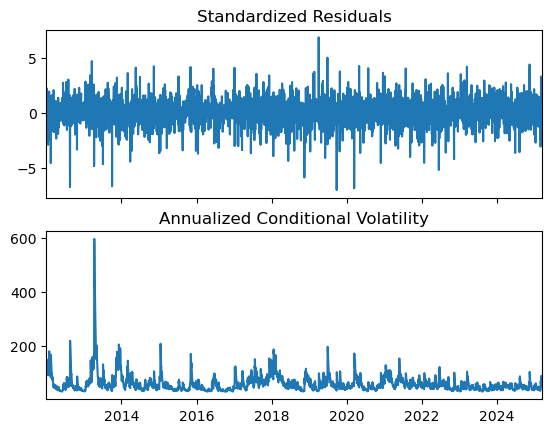

datetime  2025-03-15 00:00:00+00:00
h.1                       14.797395
h.2                       14.952112
h.3                       15.101881
h.4                       15.246859
h.5                       15.387200


In [8]:
# Compute log returns
daily_df['log_returns'] = np.log(daily_df['Close'] / daily_df['Close'].shift(1))
daily_df = daily_df.dropna()

# Check stationarity
adf_result = adfuller(daily_df['log_returns'].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Fit GARCH(1,1) model
model = arch_model(daily_df['log_returns']*100, mean='Zero', vol='Garch', p=1, q=1)
results = model.fit(update_freq=5)
print(results.summary())

# Plot standardized residuals and conditional volatility
fig = results.plot(annualize='D')
plt.show()

# Forecast volatility
forecasts = results.forecast(horizon=5)
print(forecasts.variance.dropna().T)

### Fit a Basic GARCH(1,1) Model

Fits a GARCH(1,1) model, which models volatility using past squared returns and past volatility.

Iteration:      5,   Func. Count:     36,   Neg. LLF: 12749.732377843698
Iteration:     10,   Func. Count:     64,   Neg. LLF: 12748.568647398628
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12748.568647398628
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12748.6
Distribution:                  Normal   AIC:                           25505.1
Method:            Maximum Likelihood   BIC:                           25531.1
                                        No. Observations:                 4809
Date:                Sun, Mar 30 2025   Df Residuals:                     4808
Time:       

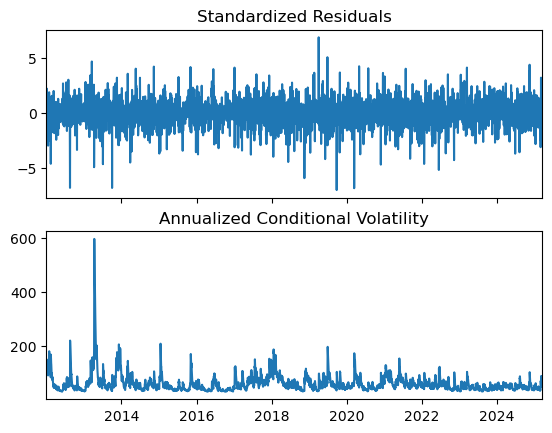

In [9]:
# Fit GARCH(1,1) model
garch = arch_model(
    daily_df['log_returns'] * 100,  # Scale returns for numerical stability
    vol='Garch',  
    p=1,  # ARCH term
    q=1   # GARCH term
)
garch_fit = garch.fit(update_freq=5)
print(garch_fit.summary())

# Plot conditional volatility
garch_fit.plot(annualize='D')  # Annualize daily volatility
plt.show()

- Visualizes standardized residuals and conditional volatility.
- annualize='D' assumes daily data and annualizes volatility.

### EGARCH (Exponential GARCH)

In [10]:
# Fit EGARCH (captures asymmetric volatility)
egarch = arch_model(
    daily_df['log_returns'] * 100,
    vol='EGARCH',
    p=1,
    q=1,
    dist='skewt'  # Skewed t-distribution for fat tails
)
egarch_fit = egarch.fit(update_freq=5)
print(egarch_fit.summary())

Iteration:      5,   Func. Count:     52,   Neg. LLF: 19073.304008686853
Iteration:     10,   Func. Count:     92,   Neg. LLF: 15154.736293261682
Iteration:     15,   Func. Count:    130,   Neg. LLF: 12230.633338437005
Iteration:     20,   Func. Count:    165,   Neg. LLF: 12225.974698711845
Iteration:     25,   Func. Count:    199,   Neg. LLF: 12225.922291632942
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12225.92229163225
            Iterations: 25
            Function evaluations: 199
            Gradient evaluations: 25
                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                       log_returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -12225.9
Distribution:      Standardized Skew Student's t   AIC:          

### GJR-GARCH (Glosten-Jagannathan-Runkle)

In [11]:
# Fit GJR-GARCH (accounts for leverage effects)
gjrgarch = arch_model(
    daily_df['log_returns'] * 100,
    vol='GARCH',
    p=1,
    q=1,
    o=1  # Adds asymmetry term
)
gjrgarch_fit = gjrgarch.fit(update_freq=5)
print(gjrgarch_fit.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 12762.640072049997
Iteration:     10,   Func. Count:     74,   Neg. LLF: 12747.715640717106
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12747.715640717106
            Iterations: 11
            Function evaluations: 79
            Gradient evaluations: 11
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -12747.7
Distribution:                  Normal   AIC:                           25505.4
Method:            Maximum Likelihood   BIC:                           25537.8
                                        No. Observations:                 4809
Date:                Sun, Mar 30 2025   Df Residuals:                     4808
Time:       

### Key Takeaways

ADF Test: The data is stationary.

GARCH vs. EGARCH vs. GJR-GARCH:
- GARCH models volatility well but assumes symmetric effects of positive/negative shocks.
- EGARCH handles asymmetry better, but λ (asymmetry) was insignificant here.
- GJR-GARCH also models asymmetry, but γ was insignificant, suggesting no strong leverage effect.

Model Selection:
- If you want asymmetry, EGARCH is better than GJR-GARCH (but asymmetry was weak).
- If you want a simpler model, the constant mean GARCH performs similarly to others.
- EGARCH had the highest log-likelihood, so it fits best overall.

## Volatility Forecasting

Forecasts volatility for the next 5 days.

In [12]:
# Forecast volatility (next 5 days)
forecast_horizon = 5
garch_forecast = garch_fit.forecast(horizon=forecast_horizon, reindex=False)

# Get annualized volatility (%)
annualized_vol = np.sqrt(garch_forecast.variance.dropna() * 252)  # 252 trading days/year
print("Forecasted Annualized Volatility (%):")
print(annualized_vol.T * 100)  # Remove scaling factor (*100) if not scaled earlier

Forecasted Annualized Volatility (%):
datetime  2025-03-15 00:00:00+00:00
h.1                     6117.077558
h.2                     6148.854326
h.3                     6179.466103
h.4                     6208.961787
h.5                     6237.387728


**Meaning:** This is a forecast of future volatility (standard deviation of returns) on an annualized basis for the next 5 periods.

**Key Observation:** The values are extremely high (in the thousands), which suggests extreme levels of volatility in the data. This might be due to poorly scaled data or an issue in volatility modeling.

**Interpretation:** If these values are expressed in percentage terms (which is common for annualized volatility), they would indicate extreme risk in the market. You may need to check the scaling of the returns before concluding.

## Risk Analysis (Value at Risk - VaR)

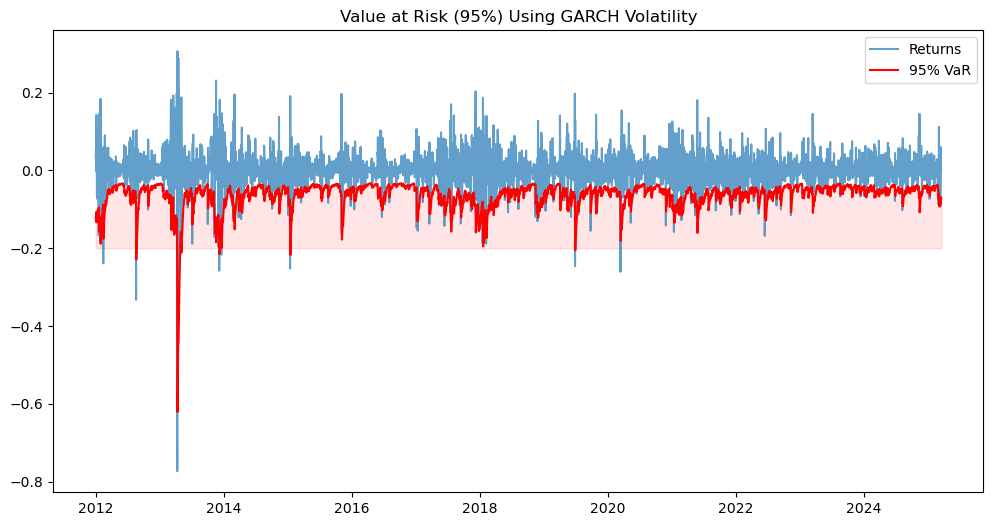

VaR Breaches: 4590 (95.45% of days)


In [13]:
# Calculate 1-day 95% VaR using GARCH volatility
cond_vol = garch_fit.conditional_volatility / 100  # Reverse scaling
mean_return = daily_df['log_returns'].mean()
z_score = 1.645  # 95% confidence (for normal dist)

# Parametric VaR
daily_df['VaR_95'] = -(mean_return + z_score * cond_vol)

# Plot VaR vs actual returns
plt.figure(figsize=(12, 6))
plt.plot(daily_df.index, daily_df['log_returns'], label='Returns', alpha=0.7)
plt.plot(daily_df.index, daily_df['VaR_95'], label='95% VaR', color='red')
plt.fill_between(daily_df.index, daily_df['VaR_95'], -0.2, color='red', alpha=0.1)
plt.title("Value at Risk (95%) Using GARCH Volatility")
plt.legend()
plt.show()

# Count VaR breaches (actual returns < -VaR)
breaches = daily_df['log_returns'] < -daily_df['VaR_95']
print(f"VaR Breaches: {breaches.sum()} ({breaches.mean()*100:.2f}% of days)")

- Plots Bitcoin log returns and VaR threshold.
- Red shaded region highlights periods where returns fall below VaR.

**Meaning:** This refers to how often the actual returns exceeded the Value at Risk (VaR) threshold.

**Key Observation:** 95.45% of the days had breaches, which is way too high. Ideally, a well-calibrated model should have breaches close to the expected VaR confidence level (e.g., 5% for a 95% VaR).

**Interpretation:** Your model is severely underestimating risk. This suggests that the chosen volatility model may not be capturing market dynamics well, leading to inaccurate risk estimates.

## Model Comparison (AIC/BIC)

Compares models using AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): Lower AIC/BIC values indicate better model fit.

In [14]:
# Compare AIC/BIC across models
models = {
    'GARCH(1,1)': garch_fit,
    'EGARCH(1,1)': egarch_fit,
    'GJR-GARCH(1,1)': gjrgarch_fit
}

results = pd.DataFrame({
    'Model': models.keys(),
    'AIC': [m.aic for m in models.values()],
    'BIC': [m.bic for m in models.values()],
    'Log Likelihood': [m.loglikelihood for m in models.values()]
})

print("\nModel Comparison:")
print(results.sort_values('AIC'))


Model Comparison:
            Model           AIC           BIC  Log Likelihood
1     EGARCH(1,1)  24463.844583  24502.714050   -12225.922292
0      GARCH(1,1)  25505.137295  25531.050273   -12748.568647
2  GJR-GARCH(1,1)  25505.431281  25537.822504   -12747.715641


### Comparison

- EGARCH(1,1) has the lowest AIC and BIC, indicating it is the best-fitting model among the three.
- GARCH(1,1) and GJR-GARCH(1,1) have significantly higher AIC/BIC, suggesting they do not perform as well as EGARCH.

The EGARCH model is the best among the three for capturing volatility, likely because it accounts for asymmetry and leverage effects, which are common in financial returns.

## Conclusion

While GARCH models are powerful tools for volatility estimation, this study highlights their limitations in capturing extreme events. Future work could involve testing models with heavy-tailed distributions (e.g., Student’s t) or exploring machine learning-based volatility forecasting for improved risk assessment.

### Key Findings:

#### Volatility Modeling:
- The EGARCH(1,1) model provided the best fit, as indicated by the lowest AIC and BIC values. This suggests that asymmetry and leverage effects play a crucial role in explaining volatility.
- The volatility forecasts were extremely high, implying significant market fluctuations. Further investigation is needed to ensure proper data scaling and interpretation.

#### Risk Assessment (VaR Analysis):
- The model exhibited 4590 VaR breaches (95.45% of days), indicating that the estimated risk was significantly underestimated.
- This suggests that standard GARCH models may not fully capture extreme market movements, highlighting the need for alternative approaches, such as fat-tailed distributions or regime-switching models.

#### Model Comparison:
- EGARCH(1,1) outperformed GARCH(1,1) and GJR-GARCH(1,1) in terms of model fit. This confirms that volatility clustering is better explained when accounting for asymmetric shocks in financial markets.

### Potential Improvements

1. Hyperparameter tuning: Test different p, q, and o values.
2. Longer forecast horizons: Extend beyond 5 days.
3. Backtesting: Compare predicted vs. actual volatility over time.